In [2]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import HMC,MCMC, NUTS
from torch.autograd import grad
import numpy as np


import matplotlib.pyplot as plt

In [3]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f'device: {device}')

device: cuda:0


In [4]:
# Generate synthetic sensor data

N_obs = 10
# t_obs = torch.linspace(0, 5, N_obs).unsqueeze(-1).to(device)
t_obs = torch.linspace(0, 5, N_obs).to(device)
u_true = (t_obs**2) / 2 + t_obs
noise_std = 0.1
u_obs = u_true + noise_std * torch.randn_like(u_true)

In [5]:
# Collocation points 

N_f = 100
#t_f = torch.linspace(0, 5, N_f).unsqueeze(-1).to(device).requires_grad_(True)
t_f = torch.linspace(0, 5, N_f).to(device).requires_grad_(True)


# Initial Point

# t_ic = torch.tensor([[0.0]], requires_grad=True).to(device)
t_ic = torch.tensor([[0.0]]).to(device)

In [6]:

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 1)
        self.act = torch.tanh

    def forward(self, t):
        z = self.act(self.layer1(t))
        x = self.act(self.layer2(z))
        return self.layer3(x)

# pinn = PINN().to(device)
pinn = PINN().to(device)

In [7]:
# Pyro probabilistic model

def model(t_obs, u_obs,t_f, t_ic):
    
    # Priors on all network parameters

    for name, param in pinn.named_parameters():
        pyro.sample(name, dist.Normal(0., 1.).expand(param.shape).to_event(param.dim()))

    # Sensor Likelihood

    u_pred_obs = pinn(t_obs)
    pyro.sample("obs", dist.Normal(u_pred_obs.squeeze(-1), noise_std).to_event(1),obs=u_obs.squeeze(-1))


    # Physics constraint

    u_pred_f = pinn(t_f)
    du_dt = torch.autograd.grad(u_pred_f, t_f, grad_outputs=torch.ones_like(u_pred_f), create_graph=True,retain_graph = True, allow_unused=True)[0]
    residual = du_dt - t_f
    
    # The factor strength (lambda) can be tuned:
    pyro.factor("physics", -1e3 * residual.pow(2).sum())


    # Initial‐condition residual factor

    u_pred_ic = pinn(t_ic)
    residual_ic = u_pred_ic - 0.0
    # penalize squared IC error
    pyro.factor("ic", -1e3 * residual_ic.pow(2).sum())


In [8]:
# Run HMC (NUTS)

nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100)
mcmc.run(t_obs, u_obs, t_f,t_ic)

Warmup:   0%|          | 0/300 [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 1x20)
     Trace Shapes:        
      Param Sites:        
     Sample Sites:        
layer1.weight dist | 20  1
             value | 20  1
  layer1.bias dist | 20   
             value | 20   
layer2.weight dist | 20 20
             value | 20 20
  layer2.bias dist | 20   
             value | 20   
layer3.weight dist |  1 20
             value |  1 20
  layer3.bias dist |  1   
             value |  1   

In [44]:
# Extract posterior samples

samples = mcmc.get_samples()

In [45]:
# Posterior predictive on a fine grid
t_test = torch.linspace(0, 5, 50).unsqueeze(-1).to(device)
predictions = []
for i in range(50):  # take first 50 posterior samples
    # Load sampled parameters into the network
    for name, param in pinn.named_parameters():
        param.data = samples[name][i].reshape(param.shape).to(device)
    with torch.no_grad():
        predictions.append(pinn(t_test).cpu().numpy())
predictions = np.stack(predictions, axis=0)  # shape [50, 50, 1]

mean_pred = predictions.mean(axis=0).squeeze(-1)
std_pred = predictions.std(axis=0).squeeze(-1)

In [46]:
print("Posterior mean at test points:", mean_pred)
print("Posterior std at test points:", std_pred)

Posterior mean at test points: [ 3.5940375   2.48105     3.2365253   5.184573    4.443715    4.042229
  2.402027    2.5570447   2.240971    2.932653    3.2088532   3.6196892
  2.9684098   2.6395304   2.6754484   2.536011    2.4705439   2.496287
  2.3334746   2.246522    1.7059054   1.829906    1.765244    1.3575517
  0.7111964   0.54669523  0.44548565  0.4904031   0.40102193  0.3902896
  0.20050125 -0.02418493 -0.35654125 -0.640804   -0.9131839  -0.9853684
 -0.6973678  -0.7153211  -1.0229839  -1.5227921  -1.4553461  -1.2140793
 -0.97140574 -0.9657487  -0.7628421  -0.616396   -0.53462785 -0.47142306
 -0.40968204 -0.30304894]
Posterior std at test points: [20.017721 20.275625 18.517294 18.685947 20.39098  19.760904 20.463867
 20.686422 21.341637 21.973734 22.235369 22.454058 22.392513 22.123238
 21.955173 21.44981  20.795189 20.783525 21.015844 21.013975 20.793262
 20.803804 20.630262 20.509956 20.486425 20.441729 20.506966 20.677153
 20.675362 20.541489 20.73387  21.055262 21.20947  21.

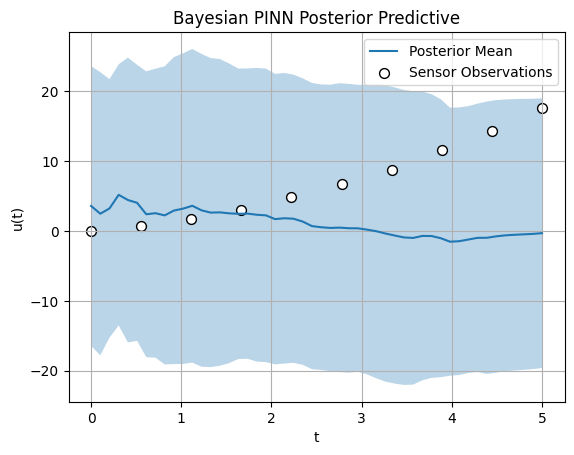

In [47]:
t_test_np = t_test.cpu().numpy().squeeze()

t_obs_np = t_obs.cpu().numpy().squeeze()
u_obs_np = u_obs.cpu().numpy().squeeze()

plt.figure()
plt.plot(t_test_np,mean_pred,label = 'Posterior Mean')

plt.fill_between(t_test_np, mean_pred - std_pred, mean_pred + std_pred, alpha = 0.3)

plt.scatter(t_obs_np, u_obs_np, marker = 'o', edgecolor='k', facecolor = 'white', s = 50, label = 'Sensor Observations')

plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Bayesian PINN Posterior Predictive')
plt.legend()
plt.grid(True)
plt.show()